In [1]:
import yaml
from joblib import load, dump
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report 
from sklearn.naive_bayes import MultinomialNB 
from sklearn.tree import DecisionTreeClassifier 
import seaborn as sns 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


In [ ]:

#Read in track metadata with genre labels
track=pd.read_csv("data\fma-rock-vs-hiphop.csv")

# Read in track metrics with the features
echonest_metrics = pd.read_json("data\echonest-metrics.json", precise_float=True)
track.head(5)


,track_id,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,...,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
0,135,256000,1,NaN,2008-11-26 01:43:26,2008-11-26 00:00:00,837,0,Rock,"[45, 58]",...,NaN,2484,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1832,NaN,0,NaN,[],Father's Day
1,136,256000,1,NaN,2008-11-26 01:43:35,2008-11-26 00:00:00,509,0,Rock,"[45, 58]",...,NaN,1948,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1498,NaN,0,NaN,[],Peel Back The Mountain Sky
2,151,192000,0,NaN,2008-11-26 01:44:55,NaN,192,0,Rock,[25],...,NaN,701,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,148,NaN,4,NaN,[],Untitled 04
3,152,192000,0,NaN,2008-11-26 01:44:58,NaN,193,0,Rock,[25],...,NaN,637,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,98,NaN,11,NaN,[],Untitled 11
4,153,256000,0,Arc and Sender,2008-11-26 01:45:00,2008-11-26 00:00:00,405,5,Rock,[26],...,NaN,354,en,Attribution-NonCommercial-NoDerivatives (aka M...,424,NaN,2,NaN,[],Hundred-Year Flood


In [3]:
echonest_metrics.head()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661
3,10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590
4,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072


In [4]:
echo_track=pd.merge(left=track[['track_id','genre_top']],right= echonest_metrics, on='track_id') 
echo_track.head()

,track_id,genre_top,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
0,153,Rock,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018
1,154,Rock,0.970135,0.352946,0.023852,0.957113,0.113261,0.032177,53.758,0.035632
2,155,Rock,0.981657,0.142249,0.912122,0.967294,0.363510,0.087527,91.912,0.034325
3,169,Rock,0.989141,0.225978,0.722835,0.263076,0.092371,0.053406,94.322,0.028347
4,170,Rock,0.886660,0.298518,0.744333,0.920950,0.139587,0.088781,97.880,0.073548


In [5]:
echo_track.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4802 entries, 0 to 4801
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          4802 non-null   int64  
 1   genre_top         4802 non-null   object 
 2   acousticness      4802 non-null   float64
 3   danceability      4802 non-null   float64
 4   energy            4802 non-null   float64
 5   instrumentalness  4802 non-null   float64
 6   liveness          4802 non-null   float64
 7   speechiness       4802 non-null   float64
 8   tempo             4802 non-null   float64
 9   valence           4802 non-null   float64
dtypes: float64(8), int64(1), object(1)
memory usage: 375.3+ KB


In [6]:
#create corrolation matrix to avoid using variables that have strong correlations with each other -- hence avoiding feature redundancy
numeric_cols=[col for col in echo_track.columns if echo_track[col].dtype in ['int64','float64']]
corr_matrix=echo_track[numeric_cols]
corr_matrix[:5].style.background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
0,153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241000,0.034018
1,154,0.970135,0.352946,0.023852,0.957113,0.113261,0.032177,53.758000,0.035632
2,155,0.981657,0.142249,0.912122,0.967294,0.363510,0.087527,91.912000,0.034325
3,169,0.989141,0.225978,0.722835,0.263076,0.092371,0.053406,94.322000,0.028347
4,170,0.886660,0.298518,0.744333,0.920950,0.139587,0.088781,97.880000,0.073548


In [7]:
features=echo_track.drop(['genre_top','track_id'], axis=1)
label=echo_track['genre_top']
scalar=StandardScaler()
scaled_train_features=scalar.fit_transform(features)
scaled_train_features

array([[ 1.36170559, -0.98589622,  1.45332318, ..., -0.36415677,
        -1.07200261, -1.57310227],
       [ 1.31234237, -0.45568108, -2.46398518, ..., -0.49822414,
        -2.14506572, -1.5670495 ],
       [ 1.34364478, -1.60400213,  1.17609079, ..., -0.11890299,
        -1.022854  , -1.57194929],
       ...,
       [-1.29470431,  1.17682795,  0.13265633, ...,  0.85182206,
        -0.93541008, -0.07941825],
       [-1.13869115, -0.02253433,  0.57117905, ...,  1.40951543,
         1.31301348,  0.47513794],
       [-0.90611434,  1.10148973,  0.56322452, ...,  1.36030881,
        -1.43669053,  0.76217464]])

In [8]:
from sklearn.decomposition import PCA 
pca=PCA()  # a technique for reducing the dimensionality of data by transforming it into a new set of variables called principal components. 
pca.fit(scaled_train_features)
exp_variance=pca.explained_variance_  #explained_variance_ is an attribute of the fitted PCA object.It is a 1D array where each element corresponds to the variance explained by each principal component.
exp_variance 

array([1.94421876, 1.44384599, 1.09225219, 1.03974362, 0.8846841 ,
       0.66431794, 0.55401802, 0.37858568])

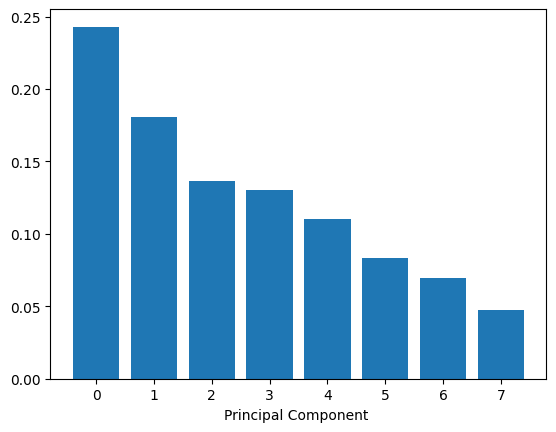

In [9]:
plt.bar(range(pca.n_components_),(pca.explained_variance_ratio_))
plt.xlabel('Principal Component ')

plt.show()

In [10]:
cum_exp=np.cumsum(exp_variance)
cum_exp

array([1.94421876, 3.38806475, 4.48031695, 5.52006057, 6.40474467,
       7.06906261, 7.62308064, 8.00166632])

In the cumulative explained variance plot, look for the "elbow" point where the increase in explained variance begins to slow down. This point indicates that adding more components yields diminishing returns.

Set a Variance Threshold: Common thresholds are 90% or 95% of the total variance. This threshold helps in determining how many components are necessary to retain most of the information.

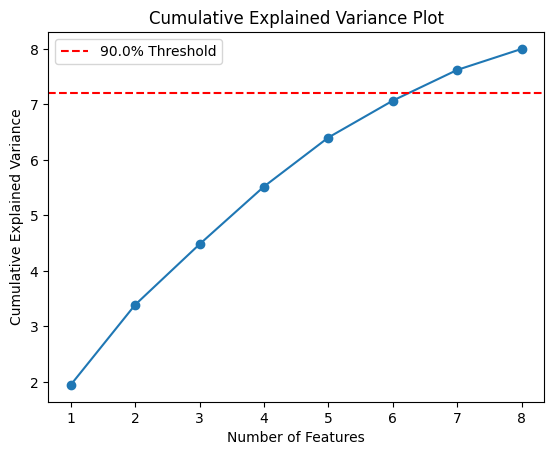

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate total variance
total_variance = cum_exp[-1]

# Set the desired threshold (e.g., 90%)
threshold_percentage = 0.90
threshold_value = total_variance * threshold_percentage

# Create the plot
fig, ax = plt.subplots()
ax.plot(range(1, len(cum_exp) + 1), cum_exp, marker='o')
ax.axhline(y=threshold_value, linestyle='--', color='r', label=f'{threshold_percentage*100}% Threshold')

# Add labels and title
ax.set_xlabel('Number of Features')
ax.set_ylabel('Cumulative Explained Variance')
ax.set_title('Cumulative Explained Variance Plot')
ax.legend()

plt.show()



In [13]:
n_components = 7  #based on the above plot, n_component would be 7
pca=PCA(n_components=7,random_state=10)

pca_projection=pca.fit_transform(scaled_train_features)
pca_projection


array([[-1.9858308 , -0.93847635,  0.25652779, ..., -0.0165219 ,
         2.01287947, -0.63327872],
       [-0.59421084, -3.65365434,  0.68686515, ..., -0.52235007,
        -0.21797971, -0.162802  ],
       [-2.26200399, -0.57382843,  1.61915489, ...,  0.7023899 ,
         1.58668597, -0.39396573],
       ...,
       [ 1.66908628,  1.84010121,  2.38294303, ...,  1.23664547,
        -0.63277253,  0.60721569],
       [ 1.17001951,  2.03158181,  0.08689922, ..., -1.45765649,
        -0.03590123, -0.02431674],
       [ 2.36368976,  1.15900708,  0.4473735 , ..., -0.03592518,
         0.82678557, -0.14947633]])

In [14]:
train_features, test_features, train_labels, test_labels= train_test_split(pca_projection,label, random_state=10, test_size=.25)
tree=DecisionTreeClassifier()
tree.fit(train_features,train_labels)
pred_labels_tree =tree.predict(test_features)


In [15]:
accuracy_score(test_labels,pred_labels_tree)

0.8759367194004996

In [16]:
test_labels.value_counts()

genre_top
Rock       972
Hip-Hop    229
Name: count, dtype: int64

In [17]:
confusion_matrix(test_labels, pred_labels_tree)


array([[147,  82],
       [ 67, 905]], dtype=int64)

Although our tree's performance is decent, it's a bad idea to immediately assume that it's therefore the perfect tool for this job -- there's always the possibility of other models that will perform even better! It's always a worthwhile idea to at least test a few other algorithms and find the one that's best for our data.

Sometimes simplest is best, and so we will start by applying logistic regression. Logistic regression makes use of what's called the logistic function to calculate the odds that a given data point belongs to a given class. Once we have both models, we can compare them on a few performance metrics, such as false positive and false negative rate (or how many points are inaccurately classified).

In [18]:
logreg= LogisticRegression(random_state=10)
logreg.fit(train_features,train_labels)
pred_labels_reg=logreg.predict(test_features)
accuracy_score(test_labels,pred_labels_reg)

0.88759367194005

In [19]:
class_rep_tree=classification_report(test_labels, pred_labels_tree)
class_rep_reg=classification_report(test_labels,pred_labels_reg)

print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_reg)

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.69      0.64      0.66       229
        Rock       0.92      0.93      0.92       972

    accuracy                           0.88      1201
   macro avg       0.80      0.79      0.79      1201
weighted avg       0.87      0.88      0.87      1201

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.79      0.55      0.65       229
        Rock       0.90      0.97      0.93       972

    accuracy                           0.89      1201
   macro avg       0.85      0.76      0.79      1201
weighted avg       0.88      0.89      0.88      1201



Balance our data for greater performance
Both our models do similarly well, boasting an average precision of 87% each. However, looking at our classification report, we can see that rock songs are fairly well classified, but hip-hop songs are disproportionately misclassified as rock songs.

Why might this be the case? Well, just by looking at the number of data points we have for each class, we see that we have far more data points for the rock classification than for hip-hop, potentially skewing our model's ability to distinguish between classes. This also tells us that most of our model's accuracy is driven by its ability to classify just rock songs, which is less than ideal.

To account for this, we can weight the value of a correct classification in each class inversely to the occurrence of data points for each class. Since a correct classification for "Rock" is not more important than a correct classification for "Hip-Hop" (and vice versa), we only need to account for differences in sample size of our data points when weighting our classes here, and not relative importance of each class.

In [20]:
hop_only=echo_track.loc[echo_track['genre_top']=='Hip-Hop']
rock_only=echo_track.loc[echo_track['genre_top']=='Rock']
rock_only.head()

,track_id,genre_top,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
0,153,Rock,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018
1,154,Rock,0.970135,0.352946,0.023852,0.957113,0.113261,0.032177,53.758,0.035632
2,155,Rock,0.981657,0.142249,0.912122,0.967294,0.363510,0.087527,91.912,0.034325
3,169,Rock,0.989141,0.225978,0.722835,0.263076,0.092371,0.053406,94.322,0.028347
4,170,Rock,0.886660,0.298518,0.744333,0.920950,0.139587,0.088781,97.880,0.073548


In [21]:
print('hop:',hop_only.shape)
print('roc: ',rock_only.shape)

hop: (910, 10)
roc:  (3892, 10)


ownsampling reduces the number of samples, which means you are discarding some data points from the majority class. This can potentially lose some information.

However, downsampling helps correct class imbalance, which otherwise can cause the model to be biased toward the majority class, leading to misleadingly high accuracy but poor performance on minority classes.

In [22]:
rock_only=rock_only.sample(n=hop_only.shape[0])   #So, this line randomly samples from rock_only exactly as many rows as there are in hop_only.
print(rock_only.shape)

(910, 10)


In [23]:
rock_hop_bal=pd.concat([rock_only,hop_only])
print(rock_hop_bal.head())

      track_id genre_top  acousticness  danceability    energy  \
3471     66665      Rock      0.629527      0.163094  0.175866   
2847     44201      Rock      0.008107      0.495146  0.857794   
917       4489      Rock      0.138172      0.233803  0.474503   
2844     44198      Rock      0.187307      0.223379  0.779994   
3482     67659      Rock      0.373589      0.634413  0.960548   

      instrumentalness  liveness  speechiness    tempo   valence  
3471          0.821524  0.150467     0.043871   89.748  0.034741  
2847          0.890353  0.138171     0.091186  114.869  0.096071  
917           0.466053  0.421841     0.068647  185.947  0.418521  
2844          0.845824  0.111873     0.040248  115.060  0.172905  
3482          0.846514  0.229396     0.075573  110.999  0.268158  


In [24]:
features=rock_hop_bal.drop(['track_id','genre_top'], axis=1)
label=rock_hop_bal['genre_top']
scaled_train_features=scalar.fit_transform(features)

pca_projection=pca.fit_transform(scaled_train_features)

train_features,test_features,train_labels,test_labels=train_test_split(features,label, test_size=.25, random_state=10)




In [41]:
tree=DecisionTreeClassifier()
tree.fit(train_features,train_labels)
pred_labels_tree=tree.predict(test_features)

regre=LogisticRegression()
regre.fit(train_features,train_labels)
pred_labels_reg=regre.predict(test_features)


# Compare the models
print("Decision Tree: \n", classification_report(test_labels, pred_labels_tree))
print("Logistic Regression: \n", classification_report(test_labels, pred_labels_reg))
print( 'accuracy_score tree', accuracy_score(test_labels,pred_labels_tree))
print( 'accuracy_score logistic regression', accuracy_score(test_labels,pred_labels_reg))

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.83      0.80      0.82       230
        Rock       0.81      0.83      0.82       225

    accuracy                           0.82       455
   macro avg       0.82      0.82      0.82       455
weighted avg       0.82      0.82      0.82       455

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.86      0.83      0.84       230
        Rock       0.83      0.86      0.84       225

    accuracy                           0.84       455
   macro avg       0.84      0.84      0.84       455
weighted avg       0.84      0.84      0.84       455

accuracy_score tree 0.8175824175824176
accuracy_score logistic regression 0.843956043956044


c:\Users\mina\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Using cross-validation to evaluate our models
Success! Balancing our data has removed bias towards the more prevalent class. To get a good sense of how well our models are actually performing, we can apply what's called cross-validation (CV). This step allows us to compare models in a more rigorous fashion.

Since the way our data is split into train and test sets can impact model performance, CV attempts to split the data multiple ways and test the model on each of the splits. Although there are many different CV methods, all with their own advantages and disadvantages, we will use what's known as K-fold CV here. K-fold first splits the data into K different, equally sized subsets. Then, it iteratively uses each subset as a test set while using the remainder of the data as train sets. Finally, we can then aggregate the results from each fold for a final model performance score.

In [39]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np

kf = KFold(n_splits=10, shuffle=True, random_state=10) #n_split:5 or 10 folds are most commonly used in practice.

#5-fold: Good balance between bias and variance, and less computational cost.

#10-fold: Slightly more robust estimate, but more computation.



tree = DecisionTreeClassifier()
regre = LogisticRegression(max_iter=1000)

# Replace 'labels' with your actual target variable
tree_score = cross_val_score(tree, pca_projection, y=label, cv=kf)
regre_score = cross_val_score(regre, pca_projection, y=label, cv=kf)

print('Decision Tree accuracy:', np.mean(tree_score))
print('Logistic Regression accuracy:', np.mean(regre_score))


Decision Tree accuracy: 0.8060439560439561
Logistic Regression accuracy: 0.8521978021978022


In [54]:
new_instance = np.array([[0.988306,	0.355661,0.979774,0.973006,0.121342	,0.151740	,90.241	,0.034018]])


# Predict genre_top using the trained logistic regression model
predicted_genre = regre.predict(new_instance)[0]

print(f"Predicted genre_top: {predicted_genre}")



Predicted genre_top: Rock


c:\Users\mina\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
